In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 벡터화에 필요한 모듈 임포트하기

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 머신러닝 모델을 만들기 위한 모듈 임포트

In [17]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

## 모델 평가용 라이브러리 임포트

In [3]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## 데이터 확인하기

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [5]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


### input 데이터 출력

In [6]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


### label 데이터 출력

In [7]:
print(y_train[0])
print(y_test[0])

3
3


### 데이터 분포 확인해보기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


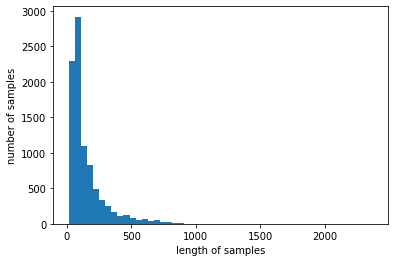

In [8]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

평균 길이에 비해 튀는 데이터가 좀 있어보임.

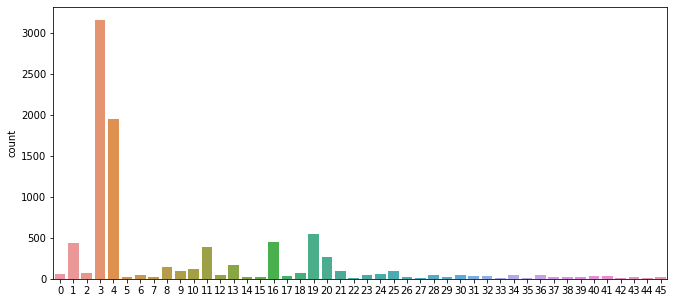

In [9]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

3, 4번 클래스에 많은 데이터가 분포함을 볼 수 있음.

In [10]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 훈련을 위한 데이터 로드 함수

In [11]:
def get_vocabulary():
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
    return word_index, index_to_word

In [12]:
def decode_data(data, index_to_word):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

In [13]:
def vectorize(x_train, x_test, Vectorizer):
    vector = Vectorizer()
    x_train_vec = vector.fit_transform(x_train)
    x_test_vec = vector.transform(x_test)
    return x_train_vec, x_test_vec

In [19]:
# 모델에 넣는 하이퍼파라미터항을 위해 **kwargs 사용
def train_and_test_model(dataset, ModelToUse, **kwargs):
    x_train, y_train, x_test, y_test = dataset
    model = ModelToUse(**kwargs)
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    # 특정 라벨로 쏠린 데이터이므로 f1 score의 평균에는 weighted를 사용한다.
    return accuracy_score(y_test, predicted), f1_score(y_test, predicted, average="weighted")

In [41]:
def process(num_words):
    metrics = {}
    
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    num_classes = max(y_train) + 1
    
    word_index, index_to_word = get_vocabulary()
    
    x_train = decode_data(x_train, index_to_word)
    x_test = decode_data(x_test, index_to_word)
    
    # 먼저 dtm을 만들고 tfidf를 만든다.
    x_train_dtm, x_test_dtm = vectorize(x_train, x_test, CountVectorizer)
    x_train_tfidf, x_test_tfidf = vectorize(x_train_dtm, x_test_dtm, TfidfTransformer)
    
    dataset = x_train_tfidf, y_train, x_test_tfidf, y_test
    
    metrics["MultinomialNB"] = train_and_test_model(dataset, MultinomialNB)
    print("MultinomialNB done!")
    
    metrics["ComplementNB"] = train_and_test_model(dataset, ComplementNB)
    print("ComplementNB done!")
    
    metrics["RandomForest"] = train_and_test_model(dataset, 
                                                   RandomForestClassifier,
                                                   n_estimators=5,
                                                   random_state=0)
    print("RandomForest done!")
    
    metrics["LogisticRegression"] = train_and_test_model(dataset, 
                                        LogisticRegression, 
                                        C=10000, 
                                        penalty='l2', 
                                        max_iter=3000,
                                        n_jobs=4)
    print("LogisticRegression done!")
    
    metrics["LinearSVC"] = train_and_test_model(dataset, 
                                        LinearSVC, 
                                        C=1000, 
                                        penalty='l1', 
                                        max_iter=3000,
                                        dual=False)
    print("LinearSVC done!")
    
    metrics["DecisionTree"] = train_and_test_model(dataset, 
                                                   DecisionTreeClassifier,
                                                   max_depth=10,
                                                   random_state=0)
    print("DecisionTree done!")
    
    metrics["GradientBoosting"] = train_and_test_model(dataset, 
                                                       GradientBoostingClassifier, 
                                                       random_state=0)
    print("GradientBoosting done!")
    
    metrics["Voting"] = train_and_test_model(dataset,
                                            VotingClassifier,
                                            estimators=[
                                                ('cnb', ComplementNB()),
                                                ('lr', LogisticRegression(C=10000, 
                                                                        penalty='l2', 
                                                                        max_iter=3000)),
                                                ('gb', GradientBoostingClassifier(random_state=0))
                                            ],
                                            n_jobs=4,
                                            voting="soft")
    print("Voting done!")
    
    return metrics

In [34]:
metric_dict = {}

In [40]:
metric_dict[3000] = process(3000)

MultinomialNB done!
ComplementNB done!
RandomForest done!
LogisticRegression done!
LinearSVC done!
DecisionTree done!
GradientBoosting done!
Voting done!


{}

In [44]:
for num_words in [5000, 10000, None]:
    print(f"{num_words} start")
    metric_dict[num_words] = process(num_words)

5000 start
MultinomialNB done!
ComplementNB done!
RandomForest done!
LogisticRegression done!


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC done!
DecisionTree done!
GradientBoosting done!
Voting done!
10000 start
MultinomialNB done!
ComplementNB done!
RandomForest done!
LogisticRegression done!


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC done!
DecisionTree done!
GradientBoosting done!
Voting done!
None start
MultinomialNB done!
ComplementNB done!
RandomForest done!
LogisticRegression done!


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC done!
DecisionTree done!
GradientBoosting done!
Voting done!


In [81]:
for num_words in [7500, 20000]:
    print(f"{num_words} start")
    metric_dict[num_words] = process(num_words)

7500 start
MultinomialNB done!
ComplementNB done!
RandomForest done!
LogisticRegression done!


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC done!
DecisionTree done!
GradientBoosting done!
Voting done!
20000 start
MultinomialNB done!
ComplementNB done!
RandomForest done!
LogisticRegression done!


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC done!
DecisionTree done!
GradientBoosting done!
Voting done!


## 학습 및 평가 완료 후 결과 시각화

In [83]:
num_words_list = [3000, 5000, 7500, 10000, 20000, None]
model_names = [
    "MultinomialNB", 
    "ComplementNB",
    "LogisticRegression", 
    "LinearSVC", 
    "DecisionTree",
    "RandomForest",
    "GradientBoosting",
    "Voting",
]
num_words_str_list = ["3000", "5000", "7500", "10000", "20000", "ALL"]

아래와 같이 raw data가 나왔음을 확인함. 대충봤을때는 뭐 눈에 띄는 차이는 없어보인다..?

In [84]:
metric_dict

{3000: {'MultinomialNB': (0.6874443455031166, 0.6266168450864102),
  'ComplementNB': (0.7644701691896705, 0.7369718160654114),
  'RandomForest': (0.6856634016028496, 0.6591675010462239),
  'LogisticRegression': (0.7880676758682101, 0.7837257156308677),
  'LinearSVC': (0.755120213713268, 0.7525614756729769),
  'DecisionTree': (0.6260017809439002, 0.580006731123168),
  'GradientBoosting': (0.7756010685663401, 0.7721347069617571),
  'Voting': (0.8018699910952805, 0.797775271024081)},
 5000: {'MultinomialNB': (0.6731967943009796, 0.6012501291711391),
  'ComplementNB': (0.7707034728406055, 0.7458990404916549),
  'RandomForest': (0.701246660730187, 0.6770217603524399),
  'LogisticRegression': (0.8032056990204809, 0.798117239672926),
  'LinearSVC': (0.7791629563668745, 0.7751008647830485),
  'DecisionTree': (0.6179875333926982, 0.5729970881280324),
  'GradientBoosting': (0.767586821015138, 0.7662475269931749),
  'Voting': (0.8103294746215495, 0.8075925840297229)},
 10000: {'MultinomialNB': (0

시각화를 위해 데이터를 정리한다. 먼저, model별로 정리해본다. 그후 num_words별로도 정리해준다.

In [85]:
model_accuracy_dict = {}
model_f1_dict = {}

for model_name in model_names:
    accuracy_result = []
    f1_result = []
        
    for num_words in num_words_list:
        accuracy_result.append(metric_dict[num_words][model_name][0])
        f1_result.append(metric_dict[num_words][model_name][1])
    model_accuracy_dict[model_name] = accuracy_result
    model_f1_dict[model_name] = f1_result

In [86]:
words_accuracy_dict = {}
words_f1_dict = {}

for num_words in num_words_list:
    accuracy_result = []
    f1_result = []
    for model_name in model_names: 
        accuracy_result.append(metric_dict[num_words][model_name][0])
        f1_result.append(metric_dict[num_words][model_name][1])
    
    if num_words is None:
        num_words = "ALL"
    words_accuracy_dict[num_words] = accuracy_result
    words_f1_dict[num_words] = f1_result

### 모델에 따른 accuracy, f1 score 시각화

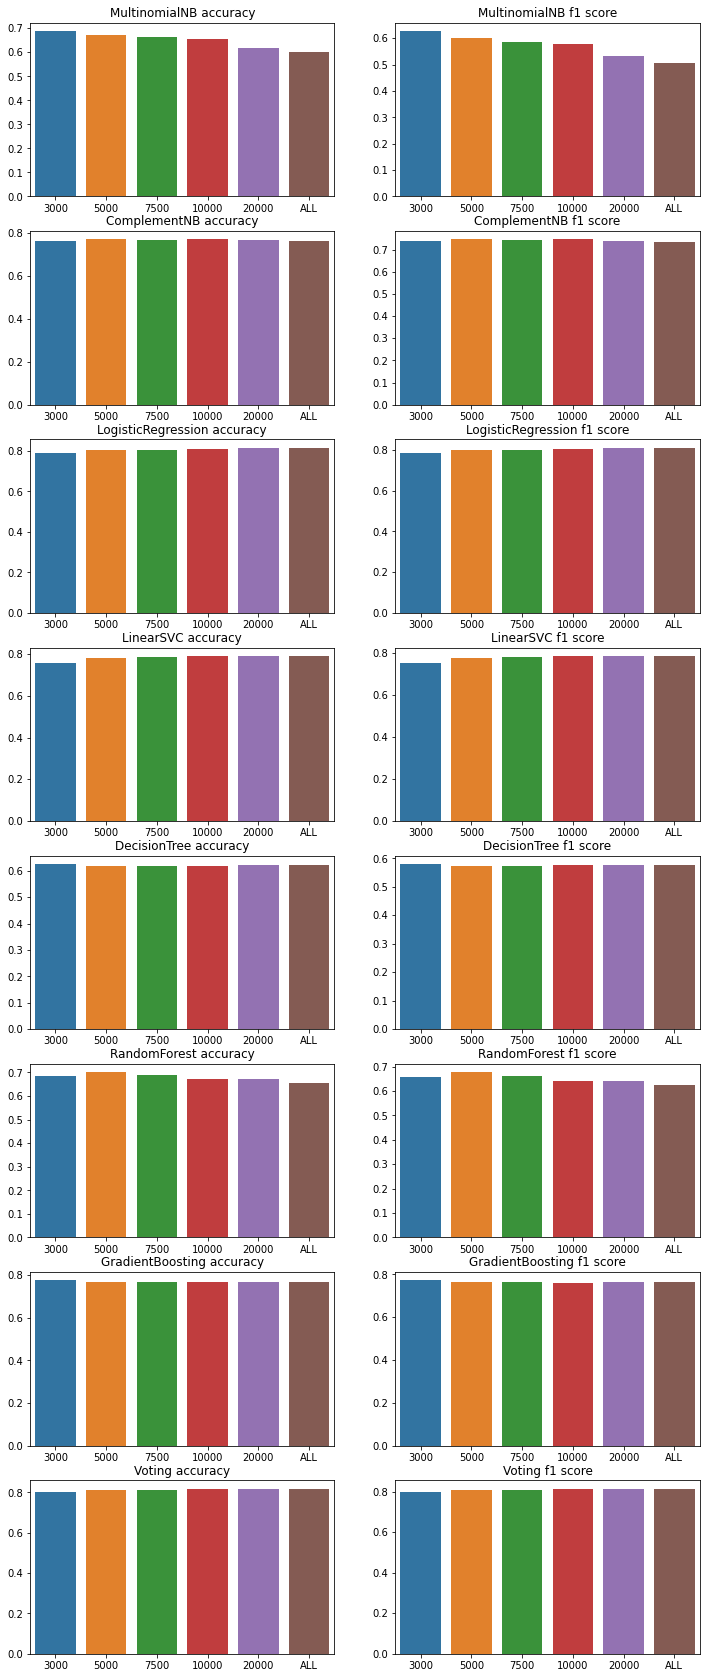

In [87]:
# plt.subplots(len(model_names), 2)
plt.figure(figsize=(12, 30))
for idx, model_name in enumerate(model_names):
    plt.subplot(len(model_names), 2, 2 * idx + 1)
    sns.barplot(x=num_words_str_list, y=model_accuracy_dict[model_name])
    plt.title(f"{model_name} accuracy")
    
    plt.subplot(len(model_names), 2, 2 * idx + 2)
    sns.barplot(x=num_words_str_list, y=model_f1_dict[model_name])
    plt.title(f"{model_name} f1 score")

대부분의 모델에서 num_words의 크기와 상관없이 비교적 균일해보이는 결과를 얻었다.

눈에 띄게 num_words의 크기가 늘어날수록 성능이 안 좋아지는 모델이 multinominal NB와 RandomForeset가 있었다.

두 모델의 경우 num_words가 커졌을 때 과적합되지 않았을까 싶다.

반대로 LinearSVC와 Logistic Regression은 num_words가 늘어날수록 성능이 좋아지는것 같아보였다.

이는 두 모델이 정규화항이 존재하여서(각각 l1, l2) 과적합을 방지하지 않았을까 싶다

###  num_words에 따른 accuracy, f1 score 시각화

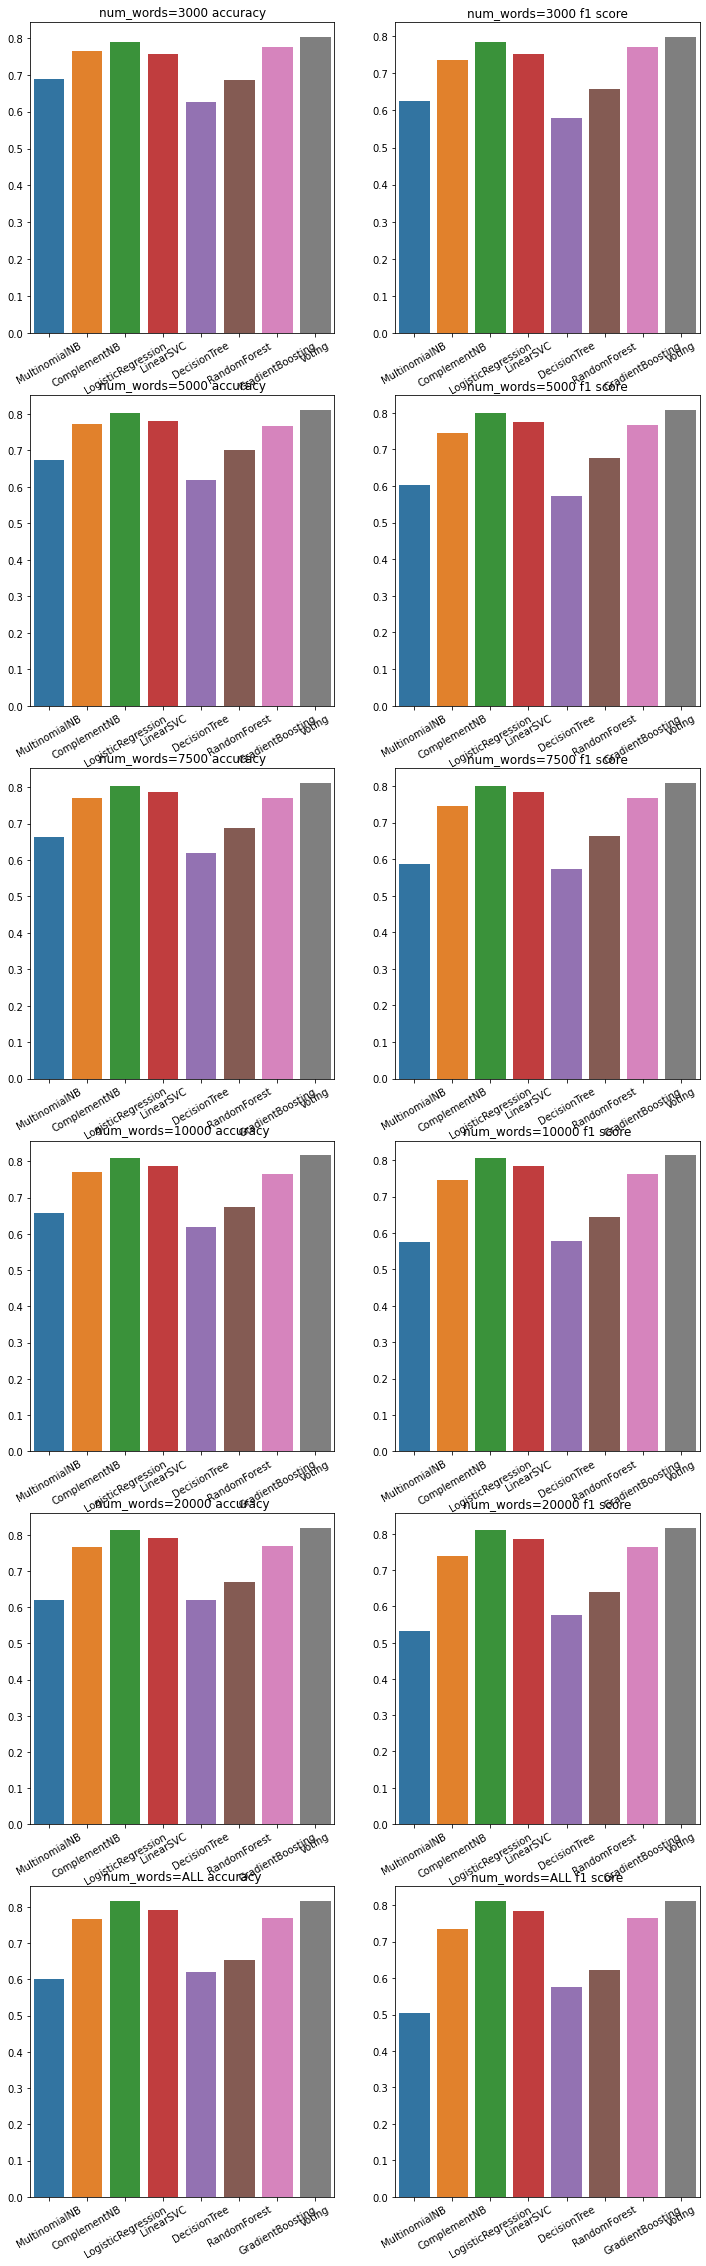

In [90]:
plt.figure(figsize=(12, 40))
for idx, num_words in enumerate(num_words_list):
    if num_words is None:
        num_words = "ALL"
    plt.subplot(len(num_words_list), 2, 2 * idx + 1)
    ax = sns.barplot(x=model_names, y=words_accuracy_dict[num_words])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.title(f"num_words={num_words} accuracy")
    
    plt.subplot(len(num_words_list), 2, 2 * idx + 2)
    ax = sns.barplot(x=model_names, y=words_f1_dict[num_words])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.title(f"num_words={num_words} f1 score")

모델 간의 비교를 해보았을때 대부분의 경우 Voting > Logistic Regression > Linear SVC > Complement NB > Gradient Boosting > Random Forest > Multinominal NB > Decision Tree 순으로 나타났다.

특이사항으로는 Multinominal NB의 경우 num_words=None (ALL)이거나 20000 경우 decision tree 보다 성능이 좋지 않음을 확인하였다.

위에서 확인했듯이 Multinominal NB가 num_words가 커질수록 비교적 성능이 떨어지는 현상이 관측된 것이 원인일듯 하다.

### 머신러닝 모델 데이터 종합

가장 좋은 모델은 num_words=20000일때 Voting을 통해 얻었다.

## 딥러닝 모델 사용 분류

In [108]:
from tensorflow import keras

In [115]:
num_words = 20000
(x_train, y_train), (x_test, y_test) = reuters.load_data(
    num_words=20000, test_split=0.2
)
num_classes = max(y_train) + 1

### 커팅과 패딩

여러번 자르면서 실험해보니 max_len이 50일떄 결과가 좋더라...

In [116]:
def cut_and_pad(sequences, max_len):
    result = []
    for seq in sequences:
        result.append(seq[:max_len])
    result = keras.preprocessing.sequence.pad_sequences(result, maxlen=max_len)
    return result

In [117]:
from sklearn.model_selection import train_test_split

max_len = 50
x_train = cut_and_pad(x_train, max_len)
x_test = cut_and_pad(x_test, max_len)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [118]:
from tensorflow import keras

input_tensor = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(num_words, 64)(input_tensor)
x = keras.layers.LSTM(64)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(input_tensor, x)

In [119]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "reuters_rnn.h5", save_best_only=True, monitor="val_accuracy"
        )
    ],
)

Epoch 1/20
113/113 [==============================] - 2s 11ms/step - loss: 2.3186 - accuracy: 0.4011 - val_loss: 1.7955 - val_accuracy: 0.5120
Epoch 2/20
113/113 [==============================] - 1s 5ms/step - loss: 1.5870 - accuracy: 0.5628 - val_loss: 1.5642 - val_accuracy: 0.5838
Epoch 3/20
113/113 [==============================] - 1s 5ms/step - loss: 1.3450 - accuracy: 0.6320 - val_loss: 1.4480 - val_accuracy: 0.6199
Epoch 4/20
113/113 [==============================] - 1s 5ms/step - loss: 1.1600 - accuracy: 0.6845 - val_loss: 1.4315 - val_accuracy: 0.6260
Epoch 5/20
113/113 [==============================] - 1s 5ms/step - loss: 1.0041 - accuracy: 0.7232 - val_loss: 1.3488 - val_accuracy: 0.6572
Epoch 6/20
113/113 [==============================] - 1s 5ms/step - loss: 0.8991 - accuracy: 0.7493 - val_loss: 1.3736 - val_accuracy: 0.6767
Epoch 7/20
113/113 [==============================] - 1s 5ms/step - loss: 0.7999 - accuracy: 0.7814 - val_loss: 1.3340 - val_accuracy: 0.6850
Epoch

In [120]:
model = keras.models.load_model("reuters_rnn.h5")
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 2ms/step - loss: 2.0230 - accuracy: 0.7008


[2.022979974746704, 0.700801432132721]

동일한 데이터셋에 최대한 동일한 전처리를 적용하여 딥러닝 모델을 통해 약 70.1%의 정확도를 갖는 모델을 만들수 있었다.

기존에 머신러닝 모델에서 81.9%의 정확도를 갖는 모델을 만들었던 것에 비해 다소 줄어든 결과를 얻었다.

딥러닝 모델이 성능이 떨어지는 이유를 두가지로 생각해보았는데 첫번째 이유는 데이터셋 불균형으로부터 오는 것이고 두번째 이유는 tf-idf 특성공학을 통해서 머신러닝 모델이 더 잘 동작하게끔 해주었기 때문이 아닐까 싶다.

## 회고

처음에는 모듈화를 통해서 머신러닝 모델 비교단계에서 최대한 중복이 없도록 조치하였다.

그후에 시각화를 통해서 머신러닝 모델간의 성능 비교를 하였다.

다음 딥러닝 모델을 만들고 테스트셋에 대한 평가를 진행하였다.

(내가 좋은 딥러닝 모델을 못만든것일지도 모르지만) 생각보다 머신러닝 모델이 유용하다는 생각이 들었다.

